In [120]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates


from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'


#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

# Stock Market Return (Excess Return)

In [121]:
from pandas.tseries.offsets import MonthEnd # 月末
Market_ret = pd.read_csv('Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
Market_ret.set_index('month', inplace=True)
Market_ret.sort_index(inplace=True)
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


# Inflation

In [122]:
inflation = pd.read_csv('inflation.csv')
inflation['month'] = pd.to_datetime(inflation['month'],format='%Y/%m/%d')
inflation.set_index('month',inplace=True)
inflation

,cpi
month,
1987-01-31,5.1
1987-02-28,5.4
1987-03-31,5.8
1987-04-30,6.7
1987-05-31,7.6
...,...
2025-03-31,-0.1
2025-04-30,-0.1
2025-05-31,-0.1


# 月度数据的预测

A simple linear regression of an asset return on one or a few lagged predictors of interest is the most popular econometric approach for testing for return predictability. For simplicity, consider a univariate predictive regression of the period- $(t + 1)$ stock market return $r_{t+1}$ on a single predictor variable $x_t$:
$$
r_{t+1}=\alpha+\beta x_{t}+\varepsilon_{t+1}
$$
where $\varepsilon_{t+1}$ is a zero-mean, unpredictable disturbance term. When $x_t$ is the inflation rate, dividend yield, book-to-price ratio, or turnover. Many researchers find that $\beta$ is significantly different from zero; that is, there is in-sample evidence of stock market return predictability.

* H0:$\beta = 0$
* H1:$\beta \ne 0$(我们需要通过理论分析，得出$\beta$的符号)

## 模型： 通货膨胀与股票预期收益率

$$
r_{t+1} = \alpha + \beta*CPI_{t-1} + \varepsilon_{t+1}
$$

两个假设：

* H1： $\beta > 0$

* H2： $\beta < 0$

这是一个非常经典且重要的资产定价问题。通货膨胀与预期股票收益率之间的关系在金融学术界经过了数十年的广泛研究和激烈辩论，至今仍没有一个完全统一的定论。这恰恰是学术研究的魅力所在，即便是同一个问题，在不同的理论框架和实证检验下，也会得出看似矛盾的结论。

---

### **引言：经典的费雪假说**

在深入探讨正反两方观点之前，我们必须先了解最基础的理论出发点——**欧文·费雪（Irving Fisher）的费雪效应**。在其最简单的形式中，名义利率等于真实利率加上预期的通货膨胀率。

> 名义收益率 ≈ 真实收益率 + 预期通货膨胀率

如果我们将这个逻辑应用到股票上，并假设股票的预期真实收益率是相对稳定的（因为它由经济体的基本生产力、风险偏好等真实变量决定），那么预期名义股票收益率应该随着预期通货膨胀率的上升而上升。这意味着，股票作为对公司实物资产（厂房、设备、存货）所有权的代表，其名义价值应该能够对冲通胀带来的货币贬值，从而保持其真实价值。

这个直观且有力的理论，构成了两者正相关关系的核心基础。然而，大量的实证研究，尤其是在20世纪70年代之后，对这一经典假说提出了严峻的挑战。

---

### **一、 通货膨胀与预期股票收益率的正相关关系论述**

支持两者存在正相关关系的逻辑主要建立在股票的“实物资产”属性上。

1.  **理论逻辑：股票作为通胀的对冲工具（Inflation Hedge）**
    *   **基本原理**：股票代表的是对公司所有权的索取权，而公司的价值根本上来自于其拥有的实物资产（Real Assets）和未来的盈利能力。在通胀环境下，产品和服务的价格会上涨，公司的名义收入和名义利润也随之增加。同时，公司拥有的厂房、土地、存货等实物资产的名义价值也会重估上升。因此，从理论上讲，股票的内在价值应该与物价水平同步上涨，从而使其名义收益率能够补偿通货膨胀带来的损失，保证投资者的真实回报。
    *   **现金流折现模型视角**：在DCF模型中，通货膨胀会同时影响未来的名义现金流（分子）和名义折现率（分母）。如果通胀能够完全、无摩擦地传导至公司的产品售价和成本，并且名义折现率也根据费雪效应完全调整，那么股票的名义价格应该上升，以反映通胀。

2.  **实证支持：长期视角下的发现**
    *   早期的许多研究未能发现正相关关系，但这可能与研究的时间窗口有关。**[Boudoukh 和 Richardson (1993)](https://www.jstor.org/stable/2117566)** 的研究是一个重要的转折点。他们通过使用更长的时间序列数据（从19世纪至今），发现当考察的持有期越长（例如5年或更长），股票收益率与通货膨胀之间的正相关关系就越显著。
    *   **结论启示**：他们的研究表明，股票在短期内可能不是一个好的通胀对冲工具，但在长期来看，其作为实物资产的保值属性会逐渐显现。这暗示了市场在短期内可能存在定价偏差或反应不足，但在长期会回归其基本面价值。

---

### **二、 通货膨胀与预期股票收益率的负相关关系论述**

尽管正相关的理论直觉很强，但在20世纪下半叶，大量的实证研究（尤其是在美国市场）却惊人地发现两者之间存在稳健的**负相关**关系。这激发了金融学家们提出多种解释。

1.  **理论逻辑与解释**
    *   **税收效应（Tax Effect）**：这是最经典的解释之一。大多数国家的税法是基于**名义利润**和**名义资本利得**来征税的，而不是真实利润或真实资本利得。
        *   **折旧**：在通胀期间，基于历史成本计算的设备折旧额，其真实价值会缩水，导致账面上的应税利润被高估。
        *   **存货**：采用“先进先出”（FIFO）会计准则的公司，其销售成本会基于较早前购买的低成本存货，而收入则是按当前的高价格计算，这同样会虚增名义利润。
        *   **资本利得税**：投资者卖出股票时，需要为名义上的价差缴税。即使股票价格的上涨仅仅是为了补偿通胀（真实收益为零），投资者依然要为这部分“虚假”的收益纳税。
        这些税收上的扭曲效应，使得通货膨胀侵蚀了公司的真实税后利润和投资者的真实税后收益，从而降低了股票的吸引力，导致其价格下跌（即预期收益率与通胀负相关）。

    *   **货币幻觉（Money Illusion）**：由诺贝尔奖得主 **Modigliani 和 Cohn (1979)** 提出的著名假说。他们认为，投资者在评估股票价值时会犯两个系统性错误：
        1.  **错误的折现率**：投资者在用现金流折现模型估值时，倾向于使用名义利率去折现公司的真实现金流（未根据通胀调整的现金流），或者未能将公司因通胀而增加的债务价值（真实负债减少）考虑在内。这导致他们系统性地低估了股票的价值。
        2.  **对盈利质量的误判**：投资者看到了公司报告的名义利润在增长，但未能充分认识到，在高通胀环境下，维持同样生产能力所需的资本重置成本也在急剧上升。因此，报告的利润质量实际上是下降的。
        由于这种普遍存在的“货币幻觉”，当通胀上升时，市场会错误地压低股价。

    *   **代理假说（Proxy Hypothesis）**：这是另一位诺贝尔奖得主 **Fama (1981)** 提出的一个更精巧的理论。他认为，股票收益率和通货膨胀之间的负相关关系是“伪相关”（Spurious Correlation），两者本身没有直接的因果联系。真正的关系是：
        1.  股票收益率与**未来的实体经济活动**（如工业产出、GDP增长）**正相关**。因为股市是经济的晴雨表。
        2.  通货膨胀率与**未来的实体经济活动**则呈现**负相关**。这在当时被称为“滞胀”（Stagflation）现象，即高通胀往往预示着未来经济的衰退。
        3.  因此，股票收益率和通货膨胀率，因为它们都与同一个变量（未来经济活动）相关，但方向相反，从而表现出了表观上的负相关关系。通胀只是实体经济活动的“代理变量”。

    *   **风险溢价与不确定性（Risk Premium & Uncertainty）**：高通胀时期往往伴随着更高的经济不确定性和政策不确定性（例如，央行会如何应对）。为了补偿这种增加的系统性风险，投资者会要求更高的风险溢价。在短期内，要求更高的预期回报率意味着更低的当前价格。因此，通胀的上升通过增加风险溢价，导致了当前股价的下跌。

2.  **实证支持：里程碑式的研究**
    *   **[Fama 和 Schwert (1977)](https://doi.org/10.1016/0304-405X(77)90014-9)** 的研究是该领域的里程碑。他们检验了1953-1971年的美国数据，发现股票收益率与预期通胀、未预期通胀以及通胀变化都存在显著的负相关关系。他们明确指出，股票在那个时期是一个“坏”的通胀对冲工具，其表现甚至不如短期国债。这项研究的结论主导了学术界很长一段时间的看法。

---

### **总结与学术洞察**

总结一下：通货膨胀与预期股票收益率的关系远非“一对一”的简单映射。它取决于多种因素的复杂互动：

1.  **时间跨度**：在短期，税收效应、不确定性和市场非理性（如货币幻觉）可能占据主导，导致负相关。但在长期，股票作为实物资产的对冲属性可能最终显现，呈现正相关。
2.  **通胀的来源和性质**：由需求拉动的温和通胀（Demand-Pull Inflation）可能伴随着经济繁荣，对股价有利。而由成本推动的通胀（Cost-Push Inflation），如石油危机，则会损害企业利润，对股价不利。
3.  **制度因素**：税法的设计、会计准则的选择以及央行的政策反应框架，都会深刻影响这一关系。例如，如果税法改革为通胀进行指数化调整，那么负相关的税收效应就会减弱。
4.  **研究样本与时期**：20世纪70-80年代的“大滞胀”时期，负相关关系尤为明显。但在其他历史时期或不同国家，这种关系可能不那么稳定。

In [123]:
reg_data = pd.merge(Market_ret, inflation, left_index=True, right_index=True,how='left')
# 使用 pandas 的 merge 函数将两个DataFrame根据索引进行合并,且执行的是左连接操作
reg_data

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,cpi
month,,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1,2.2
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1,1.0
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1,1.6
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2,1.3
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2,3.6
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3,0.6
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3,0.4
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4,0.3


In [124]:
# 导出数据
reg_data.to_csv('reg_data.csv')
# save as excel
reg_data.to_excel('reg_data.xlsx')

In [125]:
reg_data = reg_data['2000':]

## 作图 Plot

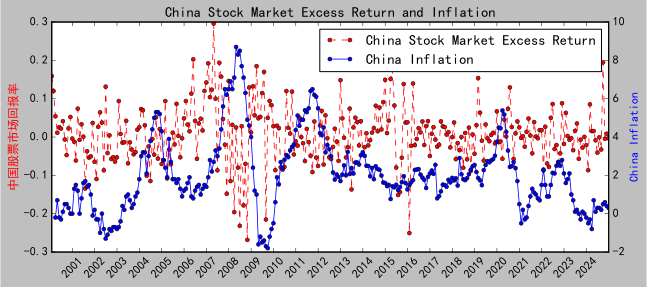

In [126]:
# 设置中文字体，以正常显示图中的中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体 (SimHei)，即可解决中文显示为□的问题
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# Plot the China's stock market return and inflation into one graph
fig, ax1 = plt.subplots(figsize=(10,4))
# the linewidth and marker size are set to be very small
ax1.plot(reg_data['ret'],color='red',marker='o',linewidth=0.8,
         markersize=4,
         linestyle='--',label='China Stock Market Excess Return')
ax1.set_ylabel('中国股票市场回报率',color='red')
#ax1.set_xlabel('Month')

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式
plt.xticks(rotation = 45)

ax2 = ax1.twinx()
ax2.plot(reg_data['cpi'].shift(2),color='blue',marker='o',linewidth=0.8,
         markersize=4,
         linestyle='-',label='China Inflation')

ax2.set_ylabel('China Inflation',color='blue')

plt.title('China Stock Market Excess Return and Inflation')

# change the legend into one box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# save figure
fig.savefig('images\L.png',dpi = 1000,bbox_inches='tight')

plt.show();

## 描述性统计 Summary


In [127]:
# 主要变量（ret, cpi）的描述性统计
reg_data[['ret','cpi']].describe().round(5)

,ret,cpi
count,300.00000,300.00000
mean,0.00668,2.02053
std,0.07576,1.92313
min,-0.26835,-1.80000
25%,-0.03981,0.80150
50%,0.00603,1.80000
75%,0.04154,2.78695
max,0.29604,8.70000


In [128]:
reg_data['ret'].skew()
reg_data['ret'].kurt()

0.00767185990102763

1.7083227513566661

In [129]:
reg_data['cpi'].skew()
reg_data['cpi'].kurt()

0.8671183992598571

1.0477799053721468

In [130]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月收益率数据进行ADF检验
adf_result = ADF(reg_data['ret'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -4.8575
p-value: 0.0000
Critical Values:
   1%: -3.4535
   5%: -2.8717
   10%: -2.5722
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [131]:
# 对cpi数据进行ADF检验
adf_result = ADF(reg_data['1995':]['cpi'])
print('\n原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')


原始序列的ADF检验结果:
ADF Statistic: -3.3288
p-value: 0.0136
Critical Values:
   1%: -3.4535
   5%: -2.8717
   10%: -2.5722
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


## OLS 回归结果

In [132]:
# Regression of return on inflation
reg_data['lcpi'] = reg_data['cpi'].shift(2)/100
model_cpi = smf.ols('ret ~ lcpi',# 表示 ret是因变量，lcpi是自变量
                 data=reg_data['2000-01':'2024-12']).fit()
print(model_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.852
Date:                Sat, 18 Oct 2025   Prob (F-statistic):            0.00317
Time:                        19:16:34   Log-Likelihood:                 353.13
No. Observations:                 298   AIC:                            -702.3
Df Residuals:                     296   BIC:                            -694.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0193      0.006      3.087      0.0

C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_10880\26271825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['lcpi'] = reg_data['cpi'].shift(2)/100


In [133]:
# Regression of return on inflation
reg_data['lcpi'] = reg_data['cpi'].shift(2)/100
model_cpi = smf.ols('ret ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
# cov_type参数用于指定在计算回归系数的协方差矩阵时所使用的方法，'HAC' 代表异方差自相关稳健协方差估计方法
# cov_kwds 是一个字典参数，用于向 cov_type 所指定的协方差估计方法传递额外的参数。'maxlags': 6 表示在 HAC 估计方法中，最大滞后阶数设置为 6
print(model_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.079
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0142
Time:                        19:16:34   Log-Likelihood:                 353.13
No. Observations:                 298   AIC:                            -702.3
Df Residuals:                     296   BIC:                            -694.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0193      0.007      2.673      0.0

C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_10880\2279434936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['lcpi'] = reg_data['cpi'].shift(2)/100


In [134]:
reg_data['lret'] = reg_data['ret'].shift(1)
model_cpi_lag = smf.ols('ret ~ lret',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi_lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.674
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0562
Time:                        19:16:34   Log-Likelihood:                 352.48
No. Observations:                 299   AIC:                            -701.0
Df Residuals:                     297   BIC:                            -693.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0052      0.005      1.126      0.2

C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_10880\2086398451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['lret'] = reg_data['ret'].shift(1)


In [135]:
reg_data['lret'] = reg_data['ret'].shift(1)
model_cpi_lag = smf.ols('ret ~ lcpi + lret',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi_lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     6.839
Date:                Sat, 18 Oct 2025   Prob (F-statistic):            0.00125
Time:                        19:16:34   Log-Likelihood:                 355.07
No. Observations:                 298   AIC:                            -704.1
Df Residuals:                     295   BIC:                            -693.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0172      0.006      2.653      0.0

C:\Users\七月柳丁\AppData\Local\Temp\ipykernel_10880\29721111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['lret'] = reg_data['ret'].shift(1)


## 预期收益率 Expected Return / Conditional Return

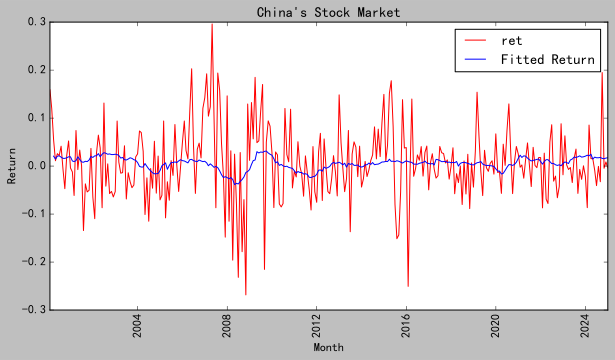

In [136]:
data = reg_data['2000-01':'2024-12'].copy()
data['fitted_return'] =  model_cpi.fittedvalues

fig = plt.figure(figsize=(10, 5))
plt.plot('ret',
         '-r',
         label='ret',
         linewidth=1,
         data=data)
plt.plot('fitted_return',
         '-b',
         label='Fitted Return',
         linewidth=1,
         data=data)
plt.title("China's Stock Market")
plt.xlabel('Month')  # 画图的x轴名称
plt.ylabel('Return')  # 画图的y轴名称

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式
plt.xticks(rotation = 90)
plt.legend()
fig.savefig('images/fitted_return.jpg', bbox_inches='tight')  # 更改输出图片格式 jpg
plt.show();

## 季度结果

In [ ]:
Q_reg_data = reg_data['1995-01':'2024-12'].resample('QE').apply({
    'ret':
    lambda x: (1 + x).prod() - 1,
    'cpi':
    lambda x: sum(x)
})
# 创建滞后列：
Q_reg_data['lag_cpi'] = Q_reg_data['cpi'].shift(1)
Q_reg_data

,ret,cpi,lag_cpi
month,,,
2000-03-31,0.368451,3.000000e-01,NaN
2000-06-30,0.059961,3.000000e-01,3.000000e-01
2000-09-30,-0.014135,8.000000e-01,3.000000e-01
2000-12-31,0.071593,2.800000e+00,8.000000e-01
2001-03-31,-0.004098,2.000000e+00,2.800000e+00
...,...,...,...
2023-12-31,-0.047820,-1.000000e+00,-2.000000e-01
2024-03-31,0.006789,-8.326673e-17,-1.000000e+00
2024-06-30,-0.034157,8.000000e-01,-8.326673e-17


In [138]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

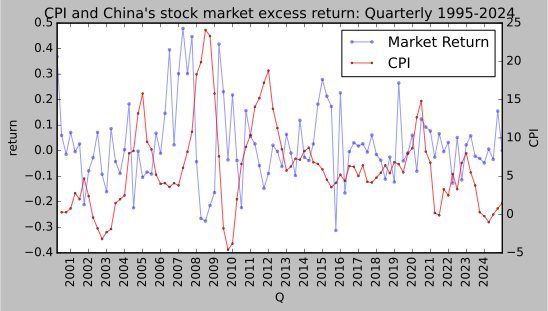

In [139]:
# Change the figure style
plt.style.use('classic')
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)  #(x, x, x)这里前两个表示几*几的网格，最后一个表示第几子图

ax1.plot(Q_reg_data['ret'],
         color='blue',
         marker='.',
         linestyle='-',
         linewidth=1,
         markersize=6,
         alpha=0.4,
         label='Market Return')
ax1.set_xlabel('Q')  # 设置横坐标标签
ax1.set_ylabel('return')  # 设置左边纵坐标标签
#ax1.legend(loc=2)  # 设置图例在左上方
ax1.set_title("CPI and China's stock market excess return: Quarterly 1995-2024")  # 给整张图命名

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation = 90) # 转置x轴的日期显示格式

ax2 = ax1.twinx()  #twinx()函数表示共享x轴
ax2.plot(Q_reg_data['lag_cpi'],
         color='red',
         marker='o',
         linestyle='-',
         linewidth=1,
         markersize=2,
         alpha=0.7,
         label='CPI')
ax2.set_ylabel('CPI')  # 设置右边纵坐标标签
#ax2.legend(loc=1)  # 设置图例在右上方

# change the legend into one box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

fig.savefig('Qcpi.pdf', bbox_inches='tight')
plt.show();

In [140]:
Q_reg_data['lcpi'] = Q_reg_data['cpi'].shift(1)
model_qcpi = smf.ols('ret ~ lcpi',
                 data=Q_reg_data['2000':'2024']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_qcpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     4.408
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0384
Time:                        19:16:35   Log-Likelihood:                 50.322
No. Observations:                  99   AIC:                            -96.64
Df Residuals:                      97   BIC:                            -91.45
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0564      0.023      2.420      0.0

In [141]:
Q_reg_data['lret'] = Q_reg_data['ret'].shift(1)
model_qcpi_lag = smf.ols('ret ~ lret',
                 data=Q_reg_data['2000':'2024']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_qcpi_lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.628
Date:                Sat, 18 Oct 2025   Prob (F-statistic):              0.108
Time:                        19:16:35   Log-Likelihood:                 50.384
No. Observations:                  99   AIC:                            -96.77
Df Residuals:                      97   BIC:                            -91.58
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0138      0.014      0.969      0.3

In [142]:
Q_reg_data['lret'] = Q_reg_data['ret'].shift(1)
model_qcpi_lag = smf.ols('ret ~ lcpi + lret',
                 data=Q_reg_data['2000':'2024']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_qcpi_lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.727
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0276
Time:                        19:16:35   Log-Likelihood:                 52.212
No. Observations:                  99   AIC:                            -98.42
Df Residuals:                      96   BIC:                            -90.64
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0455      0.019      2.409      0.0

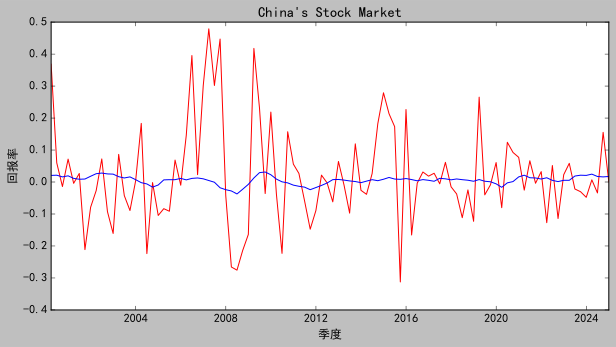

In [143]:
# 设置中文字体，以正常显示图中的中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体 (SimHei)，即可解决中文显示为□的问题
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

data = Q_reg_data['2000-01':'2024-12'].copy()
data['fitted_return'] =  model_cpi.fittedvalues

fig = plt.figure(figsize=(10, 5))
plt.plot('ret',
         '-r',
         label='ret',
         linewidth=1,
         data=data)
plt.plot('fitted_return',
         '-b',
         label='Fitted Return',
         linewidth=1,
         data=data)
plt.title("China's Stock Market")
plt.xlabel('季度')  # 画图的x轴名称
plt.ylabel('回报率')  # 画图的y轴名称

plt.show();

## 长期预测 Long Horizon Forecast

$$
r_{t+1} + r_{t+2} + r_{t+3}  =\alpha+\beta x_{t}+\varepsilon_{t+1}
$$

In [144]:
def calculate_n_month_returns(data, n):
    """
    计算从t月到t+n-1月的累计n个月收益率
    
    Parameters:
    -----------
    data : DataFrame
        包含'MarketR'和'rfmonth'列的数据框
    n : int
        累计的月份数
    
    Returns:
    --------
    DataFrame
        包含累计市场收益率、累计无风险收益率和超额收益率的数据框
    """
    # 创建结果数据框的副本
    result = data.copy()
    
    # 计算累计市场收益率 (复利)
    market_cumret = 1
    for i in range(n):
        market_cumret = market_cumret * (1 + result['MarketR'].shift(-i))
    result[f'marketret{n}'] = market_cumret - 1
    
    # 计算累计无风险收益率 (复利)
    rf_cumret = 1
    for i in range(n):
        rf_cumret = rf_cumret * (1 + result['rfmonth'].shift(-i))
    result[f'rfret{n}'] = rf_cumret - 1
    
    # 计算超额收益率
    result[f'excessret{n}'] = result[f'marketret{n}'] - result[f'rfret{n}']
    
    return result[[f'excessret{n}']]

# 使用for循环计算不同期限的累计收益率
for n in range(3, 13, 1):
    n_month_returns = calculate_n_month_returns(reg_data, n)
    reg_data = pd.concat([reg_data, n_month_returns], axis=1)

reg_data[['excessret3', 'excessret6', 'excessret12','marketret3','marketret6']].head(15)

,excessret3,excessret6,excessret12,marketret3,marketret6
month,,,,,
2000-01-31,0.369753,0.454586,0.543186,0.369753,0.454586
2000-02-29,0.194615,0.306103,0.312229,0.194615,0.306103
2000-03-31,0.093710,0.157335,0.096405,0.093710,0.157335
2000-04-30,0.060182,0.045402,0.117584,0.060182,0.045402
2000-05-31,0.091987,0.057092,0.096799,0.091987,0.057092
2000-06-30,0.057404,0.084621,0.104917,0.057404,0.084621
2000-07-31,-0.014184,0.056976,0.081888,-0.014184,0.056976
2000-08-31,-0.032261,0.002051,-0.104159,-0.032261,0.002051
2000-09-30,0.025303,-0.053650,-0.132329,0.025303,-0.053650


In [145]:
model_cpi_3month = smf.ols('excessret3 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi_3month.summary())

                            OLS Regression Results                            
Dep. Variable:             excessret3   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     5.924
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0155
Time:                        19:16:38   Log-Likelihood:                 143.93
No. Observations:                 296   AIC:                            -283.9
Df Residuals:                     294   BIC:                            -276.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0580      0.022      2.617      0.0

In [146]:
model_cpi_6month = smf.ols('excessret6 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi_6month.summary())

                            OLS Regression Results                            
Dep. Variable:             excessret6   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.065
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0447
Time:                        19:16:38   Log-Likelihood:                -26.479
No. Observations:                 293   AIC:                             56.96
Df Residuals:                     291   BIC:                             64.32
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1039      0.046      2.256      0.0

In [147]:
model_cpi_12month = smf.ols('excessret12 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(       
                        cov_type='HAC', cov_kwds={'maxlags': 6})    
print(model_cpi_12month.summary())

                            OLS Regression Results                            
Dep. Variable:            excessret12   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.792
Date:                Sat, 18 Oct 2025   Prob (F-statistic):              0.182
Time:                        19:16:38   Log-Likelihood:                -214.26
No. Observations:                 287   AIC:                             432.5
Df Residuals:                     285   BIC:                             439.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1801      0.105      1.723      0.0

In [148]:
# 使用循环生成3到12个月的回归模型
for n in range(3, 13):
    model_name = f'model_cpi_{n}month'
    formula = f'excessret{n} ~ lcpi'
    
    globals()[model_name] = smf.ols(formula,
                                     data=reg_data['2000-01':'2024-12']).fit(
                                         cov_type='HAC', cov_kwds={'maxlags': 6})

# 整理结果

In [ ]:
from statsmodels.iolib.summary2 import summary_col

info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}

# 创建模型列表
models_list = [model_cpi]
model_names_list = ["Next Month's Return"]

# 添加3到12个月的模型
for n in range(3, 13):
    model_name = f'model_cpi_{n}month'
    models_list.append(globals()[model_name])
    model_names_list.append(f"Next {n} Months' Return")

results_table = summary_col(results=models_list,
                            float_format='%0.3f',
                            stars=True,# 开启显著性星号显示，方便快速判断系数是否显著不为零
                            model_names=model_names_list,
                            info_dict=info_dict,
                            regressor_order=['Intercept', 'lcpi'])

results_table.add_title(
    'Table - OLS Regressions: Forecast Stock Market Return (1-12 Months)')

print(results_table)

                                                                                                Table - OLS Regressions: Forecast Stock Market Return (1-12 Months)
                 Next Month's Return Next 3 Months' Return Next 4 Months' Return Next 5 Months' Return Next 6 Months' Return Next 7 Months' Return Next 8 Months' Return Next 9 Months' Return Next 10 Months' Return Next 11 Months' Return Next 12 Months' Return
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept        0.019***            0.058***              0.074**               0.089**               0.104**               0.117**               0.130**               0.144**               0.156*                 0.168*                 0.180*                
                 (0.007)             (0.022)            

# CPI的自相关性

In [150]:
reg_data['lcpi'] = reg_data['cpi'].shift(1)
model_cpiself = smf.ols('cpi~lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpiself.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1501.
Date:                Sat, 18 Oct 2025   Prob (F-statistic):          3.67e-118
Time:                        19:16:38   Log-Likelihood:                -262.10
No. Observations:                 299   AIC:                             528.2
Df Residuals:                     297   BIC:                             535.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0974      0.047      2.055      0.0

In [151]:
model_cpiself = smf.ols('ret~cpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpiself.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.704
Date:                Sat, 18 Oct 2025   Prob (F-statistic):              0.101
Time:                        19:16:38   Log-Likelihood:                 351.62
No. Observations:                 300   AIC:                            -699.2
Df Residuals:                     298   BIC:                            -691.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0174      0.008      2.304      0.0

In [152]:
model_cpiself = smf.ols('ret~cpi + lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpiself.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.336
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0369
Time:                        19:16:38   Log-Likelihood:                 353.73
No. Observations:                 299   AIC:                            -701.5
Df Residuals:                     296   BIC:                            -690.4
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0177      0.008      2.339      0.0